In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8950617283950617, Loss: 0.5492466467398184
Checkpoint 200, Accuracy: 0.8950617283950617, Loss: 0.5492466467398184
Checkpoint 300, Accuracy: 0.8950617283950617, Loss: 0.5492466467398184
Checkpoint 400, Accuracy: 0.8950617283950617, Loss: 0.5492466467398184
Checkpoint 500, Accuracy: 0.8950617283950617, Loss: 0.5492466467398184


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.71954066 0.06808148 0.2123779 ]
[1. 0. 0.] <-> [0.82777834 0.06735498 0.10486674]
[1. 0. 0.] <-> [0.7611928  0.19703831 0.04176895]
[1. 0. 0.] <-> [0.66094    0.24903    0.09003001]
[0. 1. 0.] <-> [0.4225952  0.5316143  0.04579049]
[0. 1. 0.] <-> [0.44673213 0.5498211  0.00344677]
[1. 0. 0.] <-> [0.71989536 0.22673829 0.05336638]
[1. 0. 0.] <-> [0.6543227  0.05821896 0.28745833]
[1. 0. 0.] <-> [0.7283447  0.13297474 0.13868055]
[0. 0. 1.] <-> [0.50923085 0.00693772 0.48383144]
[1. 0. 0.] <-> [0.7433138  0.14090174 0.11578457]
[1. 0. 0.] <-> [0.74624497 0.1218636  0.13189149]
[1. 0. 0.] <-> [0.7005183  0.06332117 0.23616055]
[0. 0. 1.] <-> [0.4507902  0.00706972 0.5421401 ]
[0. 0. 1.] <-> [0.8755429  0.05541129 0.06904578]
[1. 0. 0.] <-> [0.7437173  0.13423268 0.12204996]
[0. 0. 1.] <-> [0.8471171  0.05587523 0.09700767]
[0. 1. 0.] <-> [0.43748567 0.5597226  0.00279175]
[1. 0. 0.] <-> [0.85337394 0.06782597 0.07880005]
[0. 1. 0.] <-> [0.33296517 0.63374376 0.03329101]


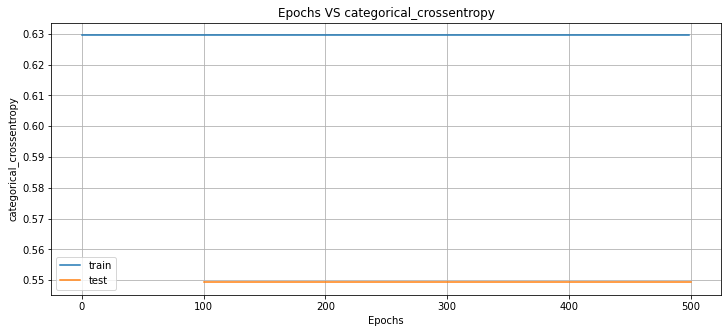

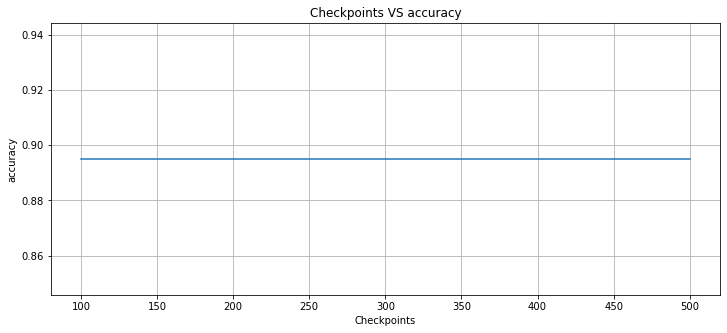

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8950617283950617, 'mean_square_error': 0.2951013892026998, 'categorical_crossentropy': 0.5492466467398184, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 16, 'tn_hit': 14, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 13}}, 'checkpoint': 100} 


{'accuracy': 0.8950617283950617, 'mean_square_error': 0.2951013892026998, 'categorical_crossentropy': 0.5492466467398184, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 16, 'tn_hit': 14, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 13}}, 'checkpoint': 200} 


{'accuracy': 0.8950617283950617, 'mean_square_error': 0.2951013892026998, 'categorical_crossentropy': 0.5492466467398184, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 16, 'tn_hit': 14, 'fn_hit': 1}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 94, 'fn

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.19870457 -0.23656559  2.6496832  -1.02049487  1.75535859]
 bias: 0.5122779690960719

Neuron 1: weights:
[ 0.14437077 -1.65344102  1.00613385  1.60600025 -1.490316  ]
 bias: -2.4466100814109994

Neuron 2: weights:
[-2.88650908 -0.72699818 -1.02578318  2.05506023  2.21399164]
 bias: 1.225124194636317

Neuron 3: weights:
[-1.43908312  1.31597102  1.6739757  -1.93952561 -2.11992484]
 bias: -1.9204688111609356

$
Layer 2
Neuron 0: weights:
[ 1.05650051  0.35854163  1.12368169 -1.28139707]
 bias: -0.614203781028348

Neuron 1: weights:
[ 0.25081672 -2.16235281  0.8298653   1.99865806]
 bias: -2.4979338288579713

Neuron 2: weights:
[-1.88446335  1.01923267  0.42594564 -2.73983205]
 bias: -0.6154006875911842

$

